##### ASakai
https://github.com/AtsushiSakai/PythonRobotics/blob/master/Localization/extended_kalman_filter/extended_kalman_filter_localization.ipynb

##### RLabbe
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/06-Multivariate-Kalman-Filters.ipynb

In [1]:
import os
import json
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

In [2]:
os.path.join(os.getcwd(), 'data')

'C:\\Users\\betty\\OneDrive\\Documents\\GitHub\\theme\\coppelia_robotics\\notebooks\\data'

In [3]:
file_path = os.path.join(os.getcwd(), 'data')
#file_path = os.path.join(os.getcwd())
drive_file = 'KF_withOdometer.json'
# message_file = 'drive_messages_200703.json'

def load_json_fstr(fstr):
    with open(os.path.join(file_path, fstr), 'r') as f:
        res = json.load(f)
    return res

drive_data = load_json_fstr(drive_file)
# message_data = load_json_fstr(message_file)

In [4]:
pprint(drive_data)
# pprint(message_data)

[{'actual_x': -3.7217729091644287,
  'actual_y': 0.21832309663295746,
  'gps_x': -3.8081783097425657,
  'gps_y': 0.1390060337466093,
  'odometer_x': -3.7217795872369606,
  'odometer_y': 0.2183607635284675},
 {'actual_x': -3.7218981981277466,
  'actual_y': 0.23484578728675842,
  'gps_x': -3.7034669749185385,
  'gps_y': 0.18500609116226538,
  'odometer_x': -3.72192572801059,
  'odometer_y': 0.2517133601360251},
 {'actual_x': -3.722267985343933,
  'actual_y': 0.2836853265762329,
  'gps_x': -3.7037764936326623,
  'gps_y': 0.26208253145946186,
  'odometer_x': -3.7221654209854242,
  'odometer_y': 0.28595340383400414},
 {'actual_x': -3.722982406616211,
  'actual_y': 0.3323434442281723,
  'gps_x': -3.6889566506754075,
  'gps_y': 0.4215435863081488,
  'odometer_x': -3.7225906654429637,
  'odometer_y': 0.32014300079101365},
 {'actual_x': -3.7244715690612793,
  'actual_y': 0.3810742497444153,
  'gps_x': -3.798347459047316,
  'gps_y': 0.42369755852666874,
  'odometer_x': -3.7232268245595903,
  'od

 {'actual_x': -3.38504421710968,
  'actual_y': 4.126631736755371,
  'gps_x': -3.342204961309402,
  'gps_y': 4.210453000730042,
  'odometer_x': -3.4685918058280634,
  'odometer_y': 3.0931087298868194},
 {'actual_x': -3.3429070711135864,
  'actual_y': 4.132055044174194,
  'gps_x': -3.429018917413811,
  'gps_y': 4.047820191616058,
  'odometer_x': -3.443038309714793,
  'odometer_y': 3.1055332455713915},
 {'actual_x': -3.2944949865341187,
  'actual_y': 4.137142181396484,
  'gps_x': -3.2833330936947225,
  'gps_y': 4.114856401322024,
  'odometer_x': -3.4109232496826416,
  'odometer_y': 3.1205745113200725},
 {'actual_x': -3.2460873126983643,
  'actual_y': 4.141239881515503,
  'gps_x': -3.2762979030379724,
  'gps_y': 4.213303491405554,
  'odometer_x': -3.3811367723661485,
  'odometer_y': 3.134082174781336},
 {'actual_x': -3.197762966156006,
  'actual_y': 4.14441978931427,
  'gps_x': -3.235243568306466,
  'gps_y': 4.0906034359012065,
  'odometer_x': -3.3516556943018156,
  'odometer_y': 3.1470618

  'odometer_x': -0.5274045149569688,
  'odometer_y': 4.207967083733748},
 {'actual_x': 1.139106035232544,
  'actual_y': 3.9991649389266968,
  'gps_x': 1.1316593928945122,
  'gps_y': 4.058969605772578,
  'odometer_x': -0.49123750635934477,
  'odometer_y': 4.221076249160412},
 {'actual_x': 1.187717318534851,
  'actual_y': 3.9966894388198853,
  'gps_x': 1.213093402718689,
  'gps_y': 4.0262671458204595,
  'odometer_x': -0.46132062334372304,
  'odometer_y': 4.232019707454873},
 {'actual_x': 1.2302699089050293,
  'actual_y': 3.9946285486221313,
  'gps_x': 1.2697203535965396,
  'gps_y': 3.925443083061198,
  'odometer_x': -0.4316823917976924,
  'odometer_y': 4.242854013173842},
 {'actual_x': 1.272713541984558,
  'actual_y': 3.992604970932007,
  'gps_x': 1.3595091332152074,
  'gps_y': 4.035489302846699,
  'odometer_x': -0.40078829996484444,
  'odometer_y': 4.254172010703317},
 {'actual_x': 1.3153281211853027,
  'actual_y': 3.990606188774109,
  'gps_x': 1.4027592210495055,
  'gps_y': 4.078492568

Set Initial Conditions

In [11]:
prior_dat = {
#     't': drive_data[0].get('t'),
    'gps_x': 0,
    'gps_y': 0, 
    'odometer_x': 0,
    'odometer_y': 0,
    'x_true':0,
    'y_true':0
#     'theta_control': drive_data[0].get('theta_control'),
#     'theta_sensor': drive_data[0].get('theta_control')
}

x_true = np.array([0, 0])

F = np.identity(2)
P = np.identity(2)
H = np.identity(2)
Q = np.zeros([2,2])
R = np.zeros([2,2])

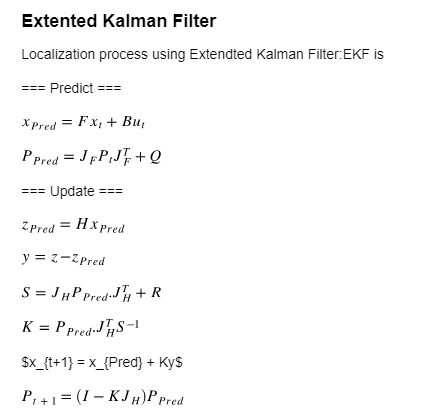

In [12]:
for i, curr_dat in enumerate(drive_data, 1):
#     dt = curr_dat['t'] - prior_dat['t']
#     u_t_sensor = np.array(
#         [curr_dat['gps_x'] - prior_dat['gps_x'],
#          curr_dat['gps_y'] - prior_dat['gps_y']])
#          curr_dat['theta_control'] - prior_dat['theta_control']])
    u_t_sensor = np.array(
        [curr_dat['gps_x'] - prior_dat['x_true'],
         curr_dat['gps_y'] - prior_dat['y_true']])
    
    u_t_control = np.array(
        [curr_dat['odometer_x'] - prior_dat['odometer_x'],
         curr_dat['odometer_y'] - prior_dat['odometer_y']])
#          curr_dat['theta_sensor'] - prior_dat['theta_sensor']])
    
    r_control = 10e-2
    J_control = np.array([
        [1, 0],
        [0, 1]])
    
    r_sensor = 10e-2
    J_sensor = np.array([
        [1, 0],
        [0, 1]])
    
        # What to plugin to alpha 1-4?
    alpha_1, alpha_2, alpha_3, alpha_4 = 10e-7, 15e-7, 5e-7, 20e-7
    alpha_1, alpha_2, alpha_3, alpha_4 = (10,) * 4
    qalpha_1, qalpha_2, qalpha_3, qalpha_4 = (1,) * 4
    
    R_t_1_1 = alpha_1 + alpha_2 
    R_t_2_2 = alpha_3 + alpha_4
    R = np.array([
        [R_t_1_1, 0],
        [0, R_t_2_2]
    ])
    
    Q_t_1_1 = qalpha_1 + qalpha_2 
    Q_t_2_2 = qalpha_3 + qalpha_4 
    Q = np.array([
        [Q_t_1_1, 0],
        [0, Q_t_2_2]
    ])
    
    # === Predict ===
    x_pred_control = x_true + u_t_control
    x_pred_sensor = x_true + u_t_sensor
    P_pred = J_control.dot(P).dot(J_control.T) + Q
    # === Update ===
    z_pred_control = H.dot(x_pred_control)
    z_pred_sensor = H.dot(x_pred_sensor)
    y = z_pred_sensor - z_pred_control
    S = J_sensor.dot(P_pred).dot(J_sensor.T) + R
    K = P_pred.dot(J_sensor.T).dot(np.linalg.inv(S))
    x_true = x_pred_control + K.dot(y)
    
    # Review
    print(
        f"x_true: {x_true}"
        # f"\nP {P}"
        f"\ny: {y}"
        f"\n"
    )
    # Setup for Next Iteration
    curr_dat['x_true'] = x_true[0]
    curr_dat['y_true'] = x_true[1]
    prior_dat = curr_dat
        

x_true: [-3.73304899  0.20801015]
y: [-0.08639872 -0.07935473]

x_true: [-3.72931754  0.23401188]
y: [ 0.02972815 -0.05635665]

x_true: [-3.72619453  0.26744722]
y: [ 0.02578074 -0.00616939]

x_true: [-3.72170719  0.31727683]
y: [0.03766312 0.11990677]

x_true: [-3.73225693  0.36076147]
y: [-0.07600411  0.0723765 ]

x_true: [-3.74493422  0.41160135]
y: [-0.09163183  0.12874097]

x_true: [-3.74484315  0.44240122]
y: [ 0.00627635 -0.02492743]

x_true: [-3.74951984  0.4894932 ]
y: [-0.03009213  0.09342634]

x_true: [-3.74703393  0.5223402 ]
y: [ 0.02637094 -0.04228067]

x_true: [-3.75430578  0.56098606]
y: [-0.0484907   0.03055456]

x_true: [-3.74643691  0.59539115]
y: [0.06726752 0.03380793]

x_true: [-3.75215244  0.63698074]
y: [-0.03518623  0.06637784]

x_true: [-3.76261536  0.68329489]
y: [-0.07056812  0.09132617]

x_true: [-3.75370622  0.72373764]
y: [0.07730643 0.07584172]

x_true: [-3.74180877  0.77615287]
y: [0.10217191 0.14192365]

x_true: [-3.73983887  0.816693  ]
y: [0.02648953

x_true: [2.04057638 4.03266257]
y: [ 0.1944845  -0.11639411]

x_true: [2.08725903 4.03529048]
y: [ 0.13753025 -0.06340869]

x_true: [2.14262352 4.04013136]
y: [ 0.18245599 -0.05295564]

x_true: [2.17631491 4.03528239]
y: [ 0.03457316 -0.11981571]

x_true: [2.22889693 4.02165351]
y: [ 0.19818455 -0.17855866]

x_true: [2.28459811 4.02679581]
y: [ 0.19658792 -0.0454679 ]

x_true: [2.32769545 4.02872551]
y: [ 0.10018284 -0.07196619]

x_true: [2.37599133 4.03351292]
y: [ 0.12539903 -0.05809196]

x_true: [2.40981923 4.04074513]
y: [ 0.03426382 -0.03290314]

x_true: [2.45447638 4.0490023 ]
y: [ 0.12388037 -0.02254654]

x_true: [2.48619101 4.04246996]
y: [ 0.01959726 -0.13877347]



In [13]:
print(drive_data[-1])

{'actual_x': 2.5990443229675293, 'actual_y': 3.937337875366211, 'odometer_x': 0.5568146854729561, 'odometer_y': 4.609535900135582, 'gps_x': 2.5032321101748267, 'gps_y': 3.9217973807530275, 'x_true': 2.486191012933144, 'y_true': 4.042469962833819}


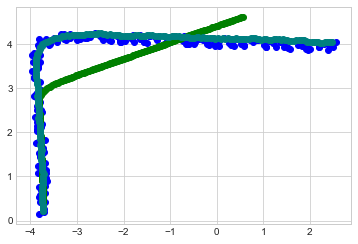

In [14]:
gps_x = [dat.get('gps_x') for dat in drive_data]
gps_y = [dat.get('gps_y') for dat in drive_data]
odometer_x = [dat.get('odometer_x') for dat in drive_data]
odometer_y = [dat.get('odometer_y') for dat in drive_data]
x_true = [dat.get('x_true') for dat in drive_data]
y_true = [dat.get('y_true') for dat in drive_data]

fig = plt.figure()
plt.plot(gps_x, gps_y, 'o', color='blue')
plt.plot(odometer_x, odometer_y, 'o', color='green')
plt.plot(x_true, y_true, 'o', color='teal')
plt.show()
# fig.savefig('plot.png')

In [11]:
print(K.dot(y))

[-0.00715885 -0.01142735]


In [12]:
print(K)

[[0.13043478 0.        ]
 [0.         0.13043478]]


In [10]:
R = np.zeros([3,3])
print(R)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
